In [8]:
import pypsa
import pandas as pd
import numpy as np

In [30]:
# =====================
# Grundparameter Standort
# =====================

roof_area = 5500                 # Gebäudefläche [m²]
number_transporter = 78          # Anzahl E-Fahrzeuge
capacitiy_battery_transporter = 40  # Batteriekapazität je Fahrzeug [kWh]
inhouse_pv = 0.35                # Max. PV-Leistung auf dem Dach [MW]

# =====================
# Wärmebedarfe (vereinfachte Annahmen)
# =====================

DHW_load_hourly = roof_area * 0.008 / 8760      # Trinkwarmwasser [MW]
Thermal_load_hourly = roof_area * 0.05 / 8760   # Raumheizung [MW]

# =====================
# Zeitprofile
# =====================

renewable_profile_solar = (pd.read_csv("ninja_pv_51.1601_13.csv", usecols=["electricity"])
    ["electricity"].astype(float)) # Stündliches, normiertes PV-Erzeugungsprofil

custom_load_profile_MW = (pd.read_csv("jahreslastgang_dhl.csv", usecols=["load_kWh"])
    ["load_kWh"].astype(float) / 1000) # Standortlastgang, von kWh/h in MW umgerechnet

# PyPSA-Netz
network = pypsa.Network()
network.set_snapshots(range(8760))  # Stündliche Auflösung übers Jahr

# Busse
network.add("Bus", name="electricity")
network.add("Bus", name="heat_0")   # Trinkwarmwasser
network.add("Bus", name="heat_1")   # Raumheizung


# Erzeugung & Netz
network.add("Generator", "PV", bus="electricity",
    p_nom=inhouse_pv,
    p_max_pu=renewable_profile_solar,
    marginal_cost=5)

network.add("Generator", "Grid", bus="electricity",
    p_nom=1.3,           # Netzanschlussleistung [MW]
    marginal_cost=300)


# Lasten (Anteile des Gesamtprofils)
network.add("Load", "Electric_Load",bus="electricity", p_set=custom_load_profile_MW * 0.15)
network.add("Load", "Fleet_Load",bus="electricity", p_set=custom_load_profile_MW * 0.7)
network.add("Load", "DHW_Load",bus="heat_0", p_set=custom_load_profile_MW * 0.05)
network.add("Load", "Thermal_Load",bus="heat_1", p_set=custom_load_profile_MW * 0.1)


# Wärmepumpen
network.add("Link", "Heat_Pump_0", bus0="electricity", bus1="heat_0",
            efficiency=3, p_nom=0.045) # roof_area* 8 [W/qm] -Recherche

network.add("Link", "Heat_Pump_1", bus0="electricity", bus1="heat_1",
            efficiency=3, p_nom=0.22) # roof_area* 40 [W/qm]  -Recherche


# Wärmespeicher
network.add("Store", "DHW_Storage",
            bus="heat_0", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)

network.add("Store", "Thermal_Storage",
            bus="heat_1", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)


Index(['Thermal_Storage'], dtype='object')

In [31]:
network.optimize(solver_name = 'gurobi')

Index(['electricity', 'heat_0', 'heat_1'], dtype='object', name='Bus')
Index(['Heat_Pump_0', 'Heat_Pump_1'], dtype='object', name='Link')
Index(['DHW_Storage', 'Thermal_Storage'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]
INFO:linopy.io: Writing time: 2.5s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-3vb19zmq.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-3vb19zmq.lp


Reading time = 0.57 seconds


INFO:gurobipy:Reading time = 0.57 seconds


obj: 148922 rows, 70082 columns, 245282 nonzeros


INFO:gurobipy:obj: 148922 rows, 70082 columns, 245282 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 148922 rows, 70082 columns and 245282 nonzeros


INFO:gurobipy:Optimize a model with 148922 rows, 70082 columns and 245282 nonzeros


Model fingerprint: 0x73f69fa0


INFO:gurobipy:Model fingerprint: 0x73f69fa0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 3e+00]


INFO:gurobipy:  Matrix range     [1e+00, 3e+00]


  Objective range  [5e+00, 3e+02]


INFO:gurobipy:  Objective range  [5e+00, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [7e-04, 1e+02]


INFO:gurobipy:  RHS range        [7e-04, 1e+02]


Presolve removed 131349 rows and 34936 columns


INFO:gurobipy:Presolve removed 131349 rows and 34936 columns


Presolve time: 0.40s


INFO:gurobipy:Presolve time: 0.40s


Presolved: 17573 rows, 35146 columns, 52772 nonzeros


INFO:gurobipy:Presolved: 17573 rows, 35146 columns, 52772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.763e+04


INFO:gurobipy: AA' NZ     : 1.763e+04


 Factor NZ  : 2.918e+05 (roughly 23 MB of memory)


INFO:gurobipy: Factor NZ  : 2.918e+05 (roughly 23 MB of memory)


 Factor Ops : 6.055e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.055e+06 (less than 1 second per iteration)


 Threads    : 10


INFO:gurobipy: Threads    : 10


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.42890201e+05 -4.46288236e+05  5.70e-01 4.58e+01  4.66e+01     1s


INFO:gurobipy:   0   5.42890201e+05 -4.46288236e+05  5.70e-01 4.58e+01  4.66e+01     1s


   1   1.79757542e+05 -8.73208478e+04  7.93e-02 2.14e+01  8.51e+00     2s


INFO:gurobipy:   1   1.79757542e+05 -8.73208478e+04  7.93e-02 2.14e+01  8.51e+00     2s


   2   1.35004112e+05  7.19749350e+04  1.46e-02 4.47e+00  1.84e+00     2s


INFO:gurobipy:   2   1.35004112e+05  7.19749350e+04  1.46e-02 4.47e+00  1.84e+00     2s


   3   1.29315589e+05  1.24360929e+05  5.83e-04 1.83e-01  1.17e-01     3s


INFO:gurobipy:   3   1.29315589e+05  1.24360929e+05  5.83e-04 1.83e-01  1.17e-01     3s


   4   1.28369099e+05  1.28205584e+05  2.46e-05 1.35e-03  3.32e-03     3s


INFO:gurobipy:   4   1.28369099e+05  1.28205584e+05  2.46e-05 1.35e-03  3.32e-03     3s


   5   1.28320157e+05  1.28237139e+05  1.29e-05 8.53e-14  1.62e-03     4s


INFO:gurobipy:   5   1.28320157e+05  1.28237139e+05  1.29e-05 8.53e-14  1.62e-03     4s


   6   1.28306941e+05  1.28246996e+05  9.63e-06 8.53e-14  1.16e-03     4s


INFO:gurobipy:   6   1.28306941e+05  1.28246996e+05  9.63e-06 8.53e-14  1.16e-03     4s


   7   1.28292213e+05  1.28252799e+05  5.96e-06 2.98e-04  7.56e-04     6s


INFO:gurobipy:   7   1.28292213e+05  1.28252799e+05  5.96e-06 2.98e-04  7.56e-04     6s


INFO:gurobipy:


Barrier performed 7 iterations in 5.99 seconds (0.20 work units)


INFO:gurobipy:Barrier performed 7 iterations in 5.99 seconds (0.20 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    9469    1.2826828e+05   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:    9469    1.2826828e+05   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Solved in 9469 iterations and 10.48 seconds (0.26 work units)


INFO:gurobipy:Solved in 9469 iterations and 10.48 seconds (0.26 work units)


Optimal objective  1.282682762e+05


INFO:gurobipy:Optimal objective  1.282682762e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70082 primals, 148922 duals
Objective: 1.28e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [21]:
# Jährlicher PV-Ertrag [MWh]
pv_generation = network.generators_t.p["PV"].sum()

# Gesamtstromverbrauch des Standorts [MWh]
total_load = network.loads_t.p.sum(axis=1).sum()

# Jährlicher Strombezug aus dem öffentlichen Netz [MWh]
grid_import = network.generators_t.p["Grid"].clip(lower=0).sum()

# Autarkiegrad [-]: Anteil des Stromverbrauchs, der ohne Netzbezug gedeckt wird
autarky = 1 - grid_import / total_load

# Elektrische Energieaufnahme der Wärmepumpe für Raumheizung [MWh]
el_heat = network.links_t.p0["Heat_Pump_1"].abs().sum()

# Erzeugte thermische Energie für Raumheizung [MWh]
th_heat = network.links_t.p1["Heat_Pump_1"].sum()

# Jahresarbeitszahl der Heizungs-Wärmepumpe [-]
JAZ_heat = th_heat / el_heat

# Elektrische Energieaufnahme der Wärmepumpe für Trinkwarmwasser [MWh]
el_dhw = network.links_t.p0["Heat_Pump_0"].abs().sum()

# Erzeugte thermische Energie für Trinkwarmwasser [MWh]
th_dhw = network.links_t.p1["Heat_Pump_0"].sum()

# Jahresarbeitszahl der Trinkwarmwasser-Wärmepumpe [-]
JAZ_dhw = th_dhw / el_dhw

# Jährlicher Energiebedarf der E-Fahrzeugflotte [MWh]
fleet_energy = network.loads_t.p["Fleet_Load"].sum()


In [22]:
print(f"PV-Ertrag: {pv_generation:.1f} MWh")
print(f"Autarkiegrad: {autarky*100:.1f} %")
print(f"JAZ Heizung: {JAZ_heat:.2f}")
print(f"JAZ DHW: {JAZ_dhw:.2f}")
print(f"E-Flotte Energiebedarf: {fleet_energy:.1f} MWh")


PV-Ertrag: 513.4 MWh
Autarkiegrad: 59.5 %
JAZ Heizung: -3.00
JAZ DHW: -3.00
E-Flotte Energiebedarf: 724.5 MWh


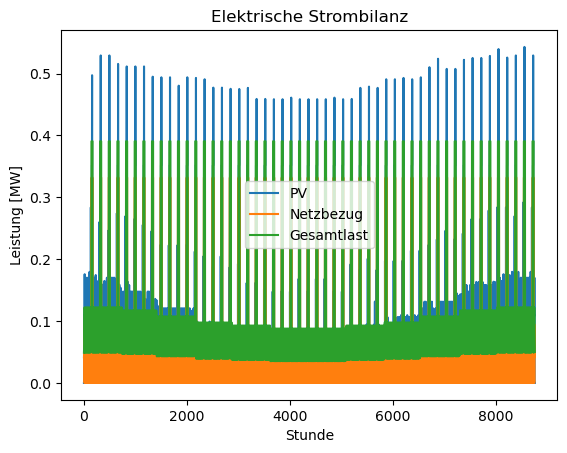

In [23]:
#Diagramme
import matplotlib.pyplot as plt

plt.figure()                                  # Neue Figure erstellen

network.generators_t.p["PV"].plot(label="PV")        # PV-Erzeugungsleistung
network.generators_t.p["Grid"].plot(label="Netzbezug")  # Leistung aus dem Stromnetz
network.loads_t.p.sum(axis=1).plot(label="Gesamtlast")  # Summe aller elektrischen Lasten

plt.ylabel("Leistung [MW]")                   # y-Achse: Leistung
plt.xlabel("Stunde")                          # x-Achse: Zeit (stündlich)
plt.legend()                                  # Legende anzeigen
plt.title("Elektrische Strombilanz")          # Diagrammtitel
plt.show()                                    # Plot anzeigen


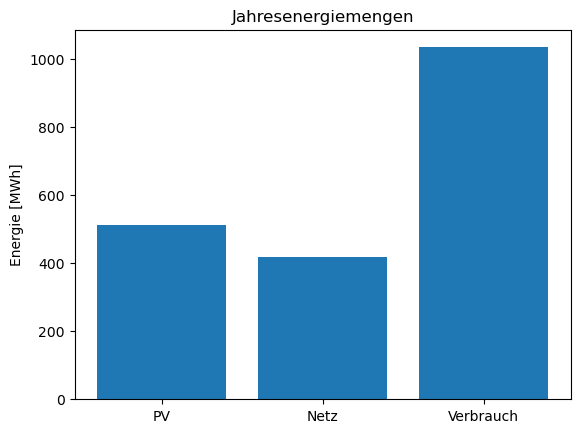

In [24]:
pv_energy = network.generators_t.p["PV"].sum()                 # Gesamtenergie der PV-Anlage [MWh]
grid_energy = network.generators_t.p["Grid"].clip(lower=0).sum()  # Bezogene Energie aus dem Netz [MWh]
total_load = network.loads_t.p.sum(axis=1).sum()               # Gesamtstromverbrauch aller Lasten [MWh]

plt.figure()                                                    # Neue Figure erstellen
plt.bar(                                                       # Balkendiagramm
    ["PV", "Netz", "Verbrauch"],                                # Kategorien
    [pv_energy, grid_energy, total_load]                       # Zugehörige Energiemengen
)
plt.ylabel("Energie [MWh]")                                    # y-Achse: Energie
plt.title("Jahresenergiemengen")                               # Diagrammtitel
plt.show()                                                     # Plot anzeigen


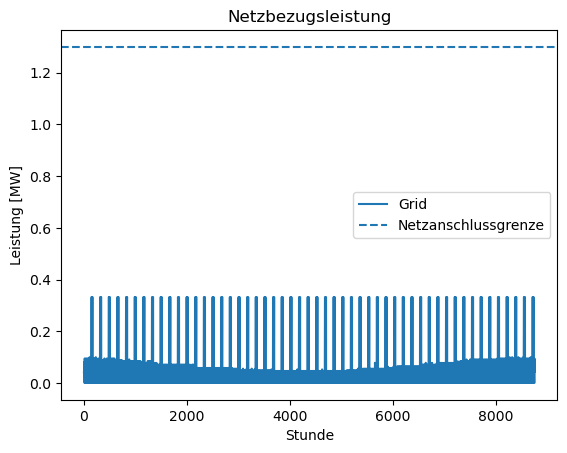

In [25]:
plt.figure()  # Neue Abbildung

network.generators_t.p["Grid"].plot(label="Netzbezug")  # Zeitlicher Verlauf der Netzleistung

plt.axhline(
    y=network.generators.loc["Grid", "p_nom"],  # Maximale Netzanschlussleistung
    linestyle="--", label="Netzanschlussgrenze")

plt.ylabel("Leistung [MW]")  # y-Achse
plt.xlabel("Stunde")         # x-Achse
plt.legend()                 # Legende anzeigen
plt.title("Netzbezugsleistung")  # Diagrammtitel
plt.show()                   # Plot anzeigen


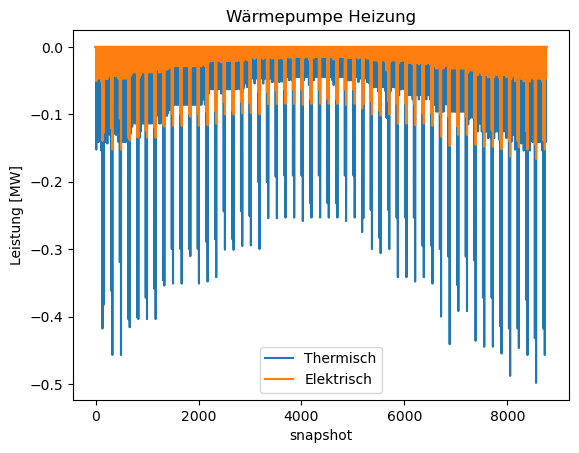

In [26]:
# Zeitlicher Verlauf der Heiz-Wärmepumpe (thermische Abgabe vs. elektrische Aufnahme)
plt.figure()

# Thermische Leistung (Wärmeabgabe der Wärmepumpe)
network.links_t.p1["Heat_Pump_1"].plot(label="Thermisch")

# Elektrische Leistungsaufnahme (Vorzeichen gedreht für Vergleich)
(-network.links_t.p0["Heat_Pump_1"]).plot(label="Elektrisch")

# Achsenbeschriftung
plt.ylabel("Leistung [MW]")

# Legende und Titel
plt.legend()
plt.title("Wärmepumpe Heizung")

# Plot anzeigen
plt.show()


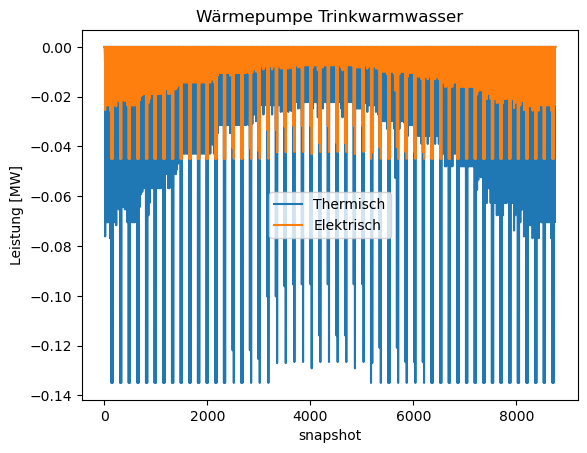

In [27]:
plt.figure()  # Neue Abbildung

network.links_t.p1["Heat_Pump_1"].plot(label="Thermisch")      # Abgegebene Wärmeleistung
(-network.links_t.p0["Heat_Pump_1"]).plot(label="Elektrisch") # Elektrische Aufnahmeleistung

plt.ylabel("Leistung [MW]")  # y-Achse
plt.legend()                 # Legende anzeigen
plt.title("Wärmepumpe Heizung")  # Diagrammtitel
plt.show()                   # Plot anzeigen


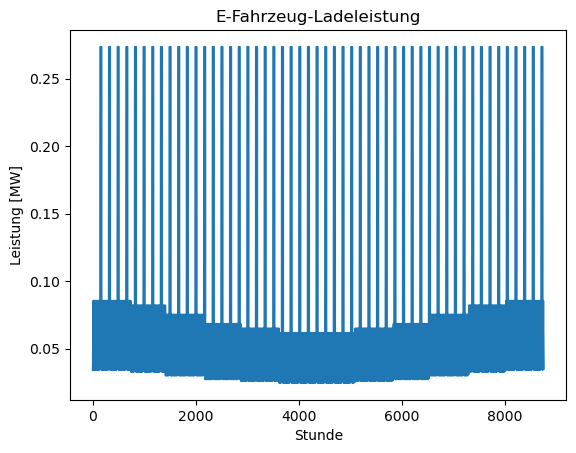

In [28]:
plt.figure()  # Neue Abbildung

network.loads_t.p["Fleet_Load"].plot()  # Ladeleistung der E-Fahrzeugflotte über die Zeit

plt.ylabel("Leistung [MW]")             # y-Achse
plt.xlabel("Stunde")                    # x-Achse
plt.title("E-Fahrzeug-Ladeleistung")    # Diagrammtitel
plt.show()                              # Plot anzeigen


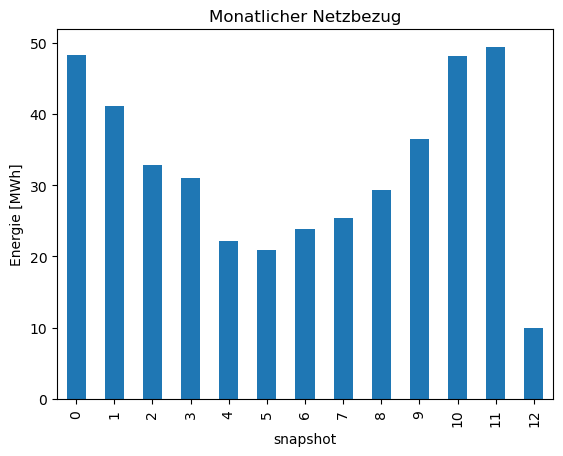

In [29]:
monthly = network.generators_t.p["Grid"].groupby(
    network.snapshots // 720          # Gruppierung in „Monate“ à 720 h (vereinfachte Monatsannahme)
).sum()                               # Aufsummieren zur Monatsenergie (MWh)

plt.figure()                          # Neue Abbildung
monthly.plot(kind="bar")             # Balkendiagramm des monatlichen Netzbezugs

plt.ylabel("Energie [MWh]")           # y-Achse: Energie
plt.title("Monatlicher Netzbezug")    # Diagrammtitel
plt.show()                            # Plot anzeigen
